# Ringdown fit from IMR results

We will show how to initialize a ringdown fit starting from a reference set of inspiral-merger-ringdown (IMR) parameter estimation (PE) samples, as would be produced in a regular GW analysis. This can be useful when launching a first exploratory fit for an event for which we have IMR results for some reference waveform.

<div class="alert alert-info">

Note

The [GWpy package](http://gwpy.github.io/) is only an _optional_ dependence for `ringdown`: you should install it before running this notebook (e.g., `pip install gwpy`); alternatively, you can download the data separately and load it directly from disk as in the GW150914 example.

</div>

In [ ]:
%pip install gwpy

## Preliminaries

We begin with some standard imports and global settings.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# disable numpy multithreading to avoid conflicts
# with jax multiprocessing in numpyro
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd

# import jax and set it up to use double precision
from jax import config
config.update("jax_enable_x64", True)

# import numpyro and set it up to use 4 CPU devices
import numpyro
numpyro.set_host_device_count(4)
numpyro.set_platform('cpu')

# we will use matplotlib, arviz and seaborn for some of the plotting
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

# disable some warning shown by importing LALSuite from a notebook
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

# import ringdown package
import ringdown as rd

# set plotting context
sns.set_context('notebook')
sns.set_palette('colorblind')

## Set up fit and run

We will first show how straightforward it is to set-up a fit automatically from the PE samples we downloaded above, and then we will explain what happened under the hood.

To set up the fit, we will use a set of posterior samples for GW150914 obtained using the `IMRPhenomXPHM` waveform in GWTC-2.1, which we can download from Zenodo.

In [ ]:
!wget -nc https://zenodo.org/records/6513631/files/IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5

Now we need only point to the file we just downloaded to create a fit automatically.

In [6]:
fit = rd.fit.Fit.from_imr_result('IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5',
                                 modes=[(1,-2,2,2,0), (1, -2,2,2,1)], cosi=-1)

waveforms:   0%|          | 0/100 [00:00<?, ?it/s]

And, it's ready to run! (This might take a couple of minutes)

In [36]:
fit.run()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

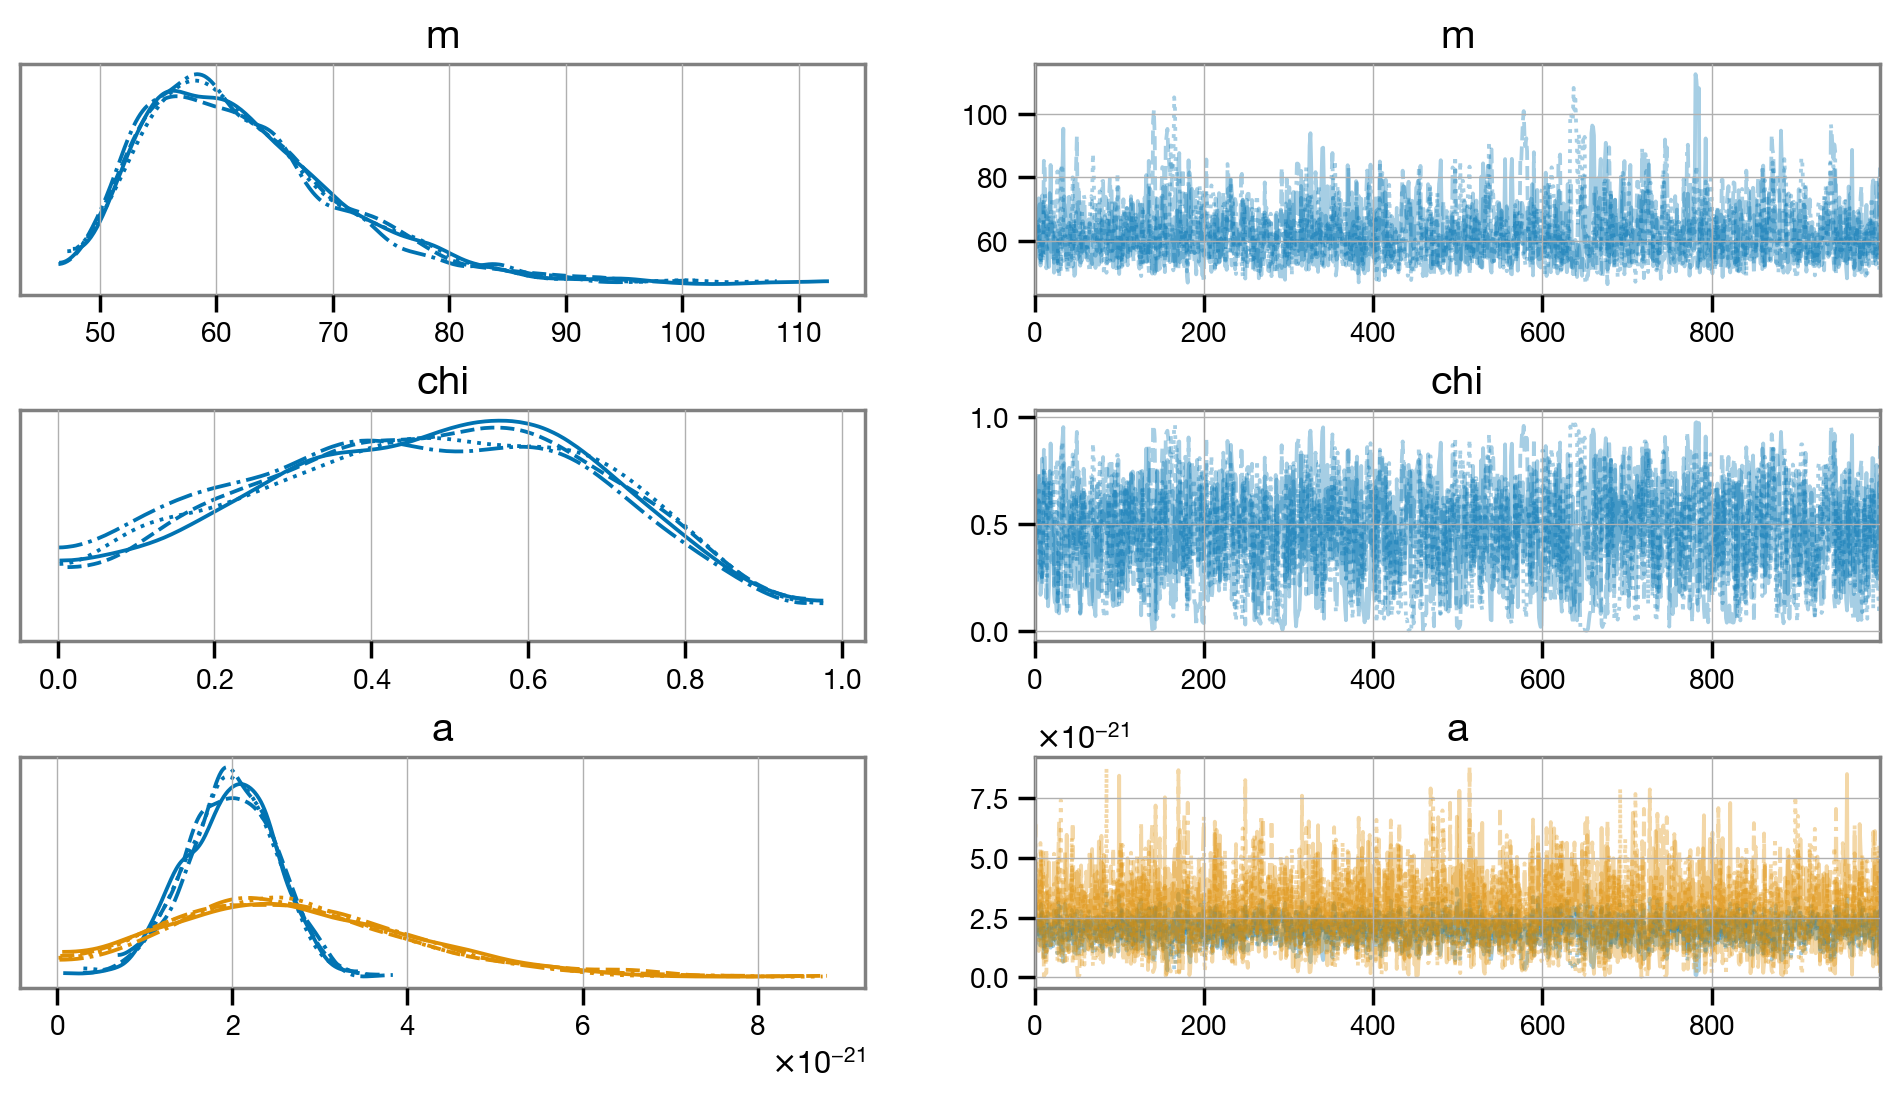

In [40]:
az.plot_trace(fit.result, var_names=['m', 'chi', 'a']);
plt.subplots_adjust(hspace=0.5)

## What just happened?

The `fit.from_imr_result` method loaded the IMR result file that we downloaded from Zenodo; together the information about the Kerr `modes` we wished to fit, as well as the inclination `cosi` we wanted to assume, `ringdown` used the IMR posterior results to initialize a fit with a best guess for the target time, analysis duration and prior ranges.

We can break down the logic that went into creating the fit above by examining the properties of the Fit. First, the IMR samples are accessible in `fit.imr_result` as an `IMRResult` object (a wrapper around a pandas `DataFrame` with some useful features).

In [39]:
fit.imr_result

,chirp_mass,mass_ratio,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,theta_jn,psi,...,viewing_angle,cos_iota,tilt_1_infinity_only_prec_avg,tilt_2_infinity_only_prec_avg,spin_1z_infinity_only_prec_avg,spin_2z_infinity_only_prec_avg,chi_eff_infinity_only_prec_avg,chi_p_infinity_only_prec_avg,cos_tilt_1_infinity_only_prec_avg,cos_tilt_2_infinity_only_prec_avg
0,29.180724,0.787959,0.924210,0.331092,1.913304,1.676054,5.394340,1.210051,2.775318,1.800080,...,0.366275,-0.768574,1.794469,2.104876,-0.205001,-0.168542,-0.188934,0.901187,-0.221812,-0.509049
1,29.953047,0.864175,0.647369,0.313305,1.841044,1.839976,3.868170,0.024863,2.660558,0.757138,...,0.481035,-0.875345,2.042512,1.387529,-0.294174,0.057098,-0.131335,0.576670,-0.454415,0.182244
2,31.433890,0.852029,0.205678,0.875008,2.365895,1.369656,2.916934,5.576937,2.493798,1.272124,...,0.647795,-0.844900,2.962913,1.292919,-0.202403,0.240028,0.001138,0.700753,-0.984079,0.274315
3,30.741031,0.980341,0.711251,0.004800,1.672429,0.627161,4.591901,0.933866,2.967835,0.886179,...,0.173758,-0.943770,1.668616,1.332239,-0.069464,0.001134,-0.034515,0.707851,-0.097664,0.236301
4,31.270597,0.930130,0.250640,0.227152,1.373358,1.525285,0.643552,6.019726,3.074509,2.418739,...,0.067084,-0.993552,0.560167,2.384433,0.212334,-0.165092,0.030453,0.143627,0.847167,-0.726790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147629,29.793946,0.721785,0.694857,0.426549,1.904654,1.440450,6.218998,0.473110,2.818321,2.597370,...,0.323271,-0.857428,1.678516,1.946527,-0.074705,-0.156523,-0.109004,0.690829,-0.107511,-0.366952
147630,30.498213,0.975876,0.270623,0.135632,1.804454,2.410538,3.755427,3.016118,2.836371,1.129183,...,0.305221,-0.950458,2.159120,1.654079,-0.150187,-0.011283,-0.081583,0.225124,-0.554968,-0.083186
147631,30.140508,0.756905,0.075144,0.794470,1.825860,1.779995,5.739989,1.122504,2.895506,1.330361,...,0.246087,-0.917919,1.294716,1.847585,0.020483,-0.217103,-0.081873,0.556026,0.272587,-0.273268
147632,29.172886,0.991457,0.292899,0.712441,1.239706,2.152905,3.206772,0.291205,2.604590,2.792774,...,0.537003,-0.844222,2.891489,1.584026,-0.283786,-0.009425,-0.147194,0.705428,-0.968887,-0.013230


The configuration file

In [44]:
snrs = fit.compute_imr_snr(optimal=True, cumulative=True, nsamp=100)

waveforms:   0%|          | 0/100 [00:00<?, ?it/s]

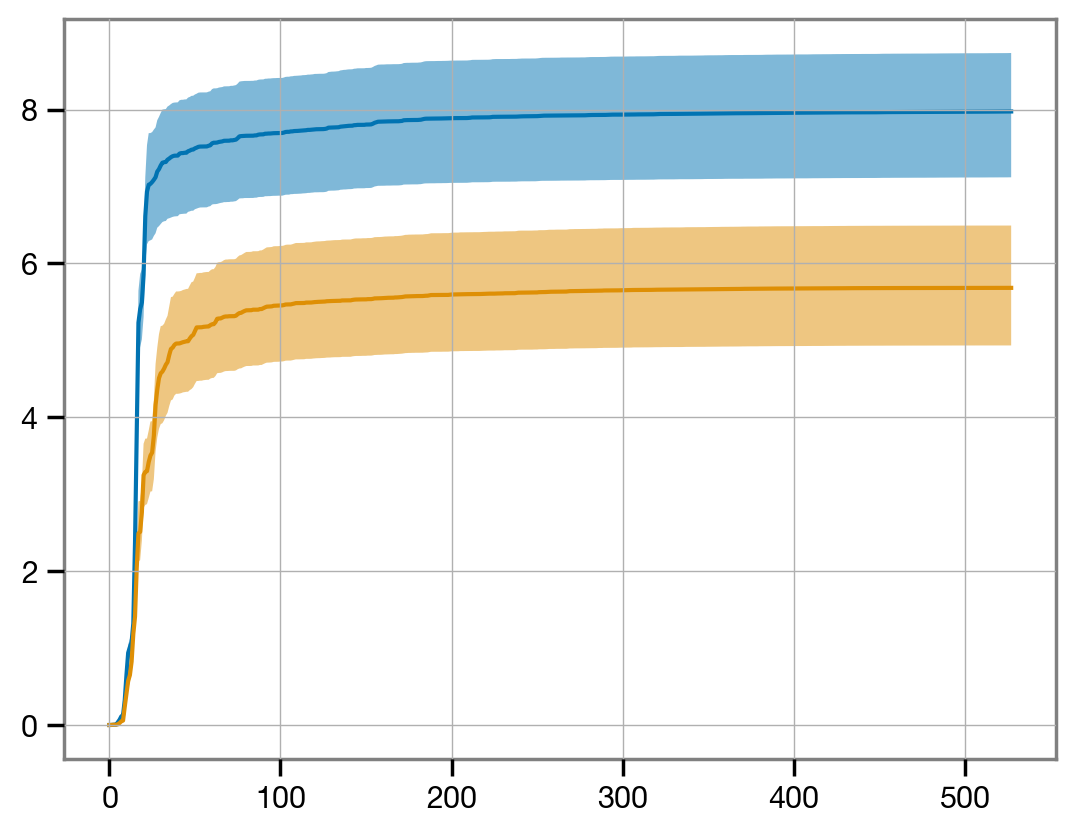

In [45]:
for s in snrs:
    l, m, h = np.quantile(s, [0.05, 0.5, 0.95], axis=1)
    plt.plot(m)
    plt.fill_between(np.arange(len(m)), l, h, alpha=0.5)

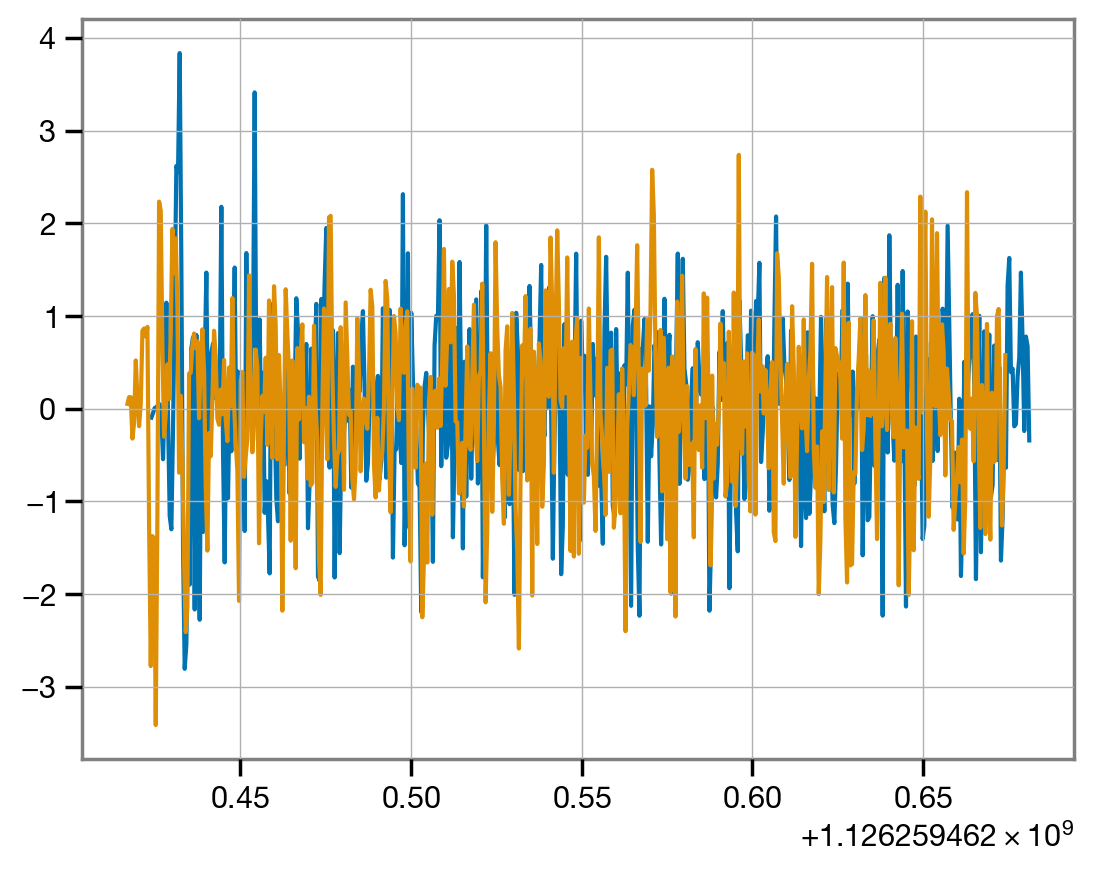

In [46]:
for i, d in fit.whitened_analysis_data.items():
    d.plot()

In [47]:
bp = fit.imr_result.get_best_peak_times()[0]

In [48]:
bt = fit.imr_result.get_best_peak_target()
print(bt)
print(fit.target)

SkyTarget(geocenter_time=LIGOTimeGPS(1126259462, 407382011), ra=2.3740998909517543, dec=-1.182031580667859, psi=0.7455033030298557, duration=0.0)
SkyTarget(geocenter_time=LIGOTimeGPS(1126259462, 407382011), ra=2.3740998909517543, dec=-1.182031580667859, psi=0.7455033030298557, duration=0.2578125)


/opt/miniconda3/envs/ringdown-jax/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/ringdown-jax/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/miniconda3/envs/ringdown-jax/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/miniconda3/envs/ringdown-jax/lib/python3.12

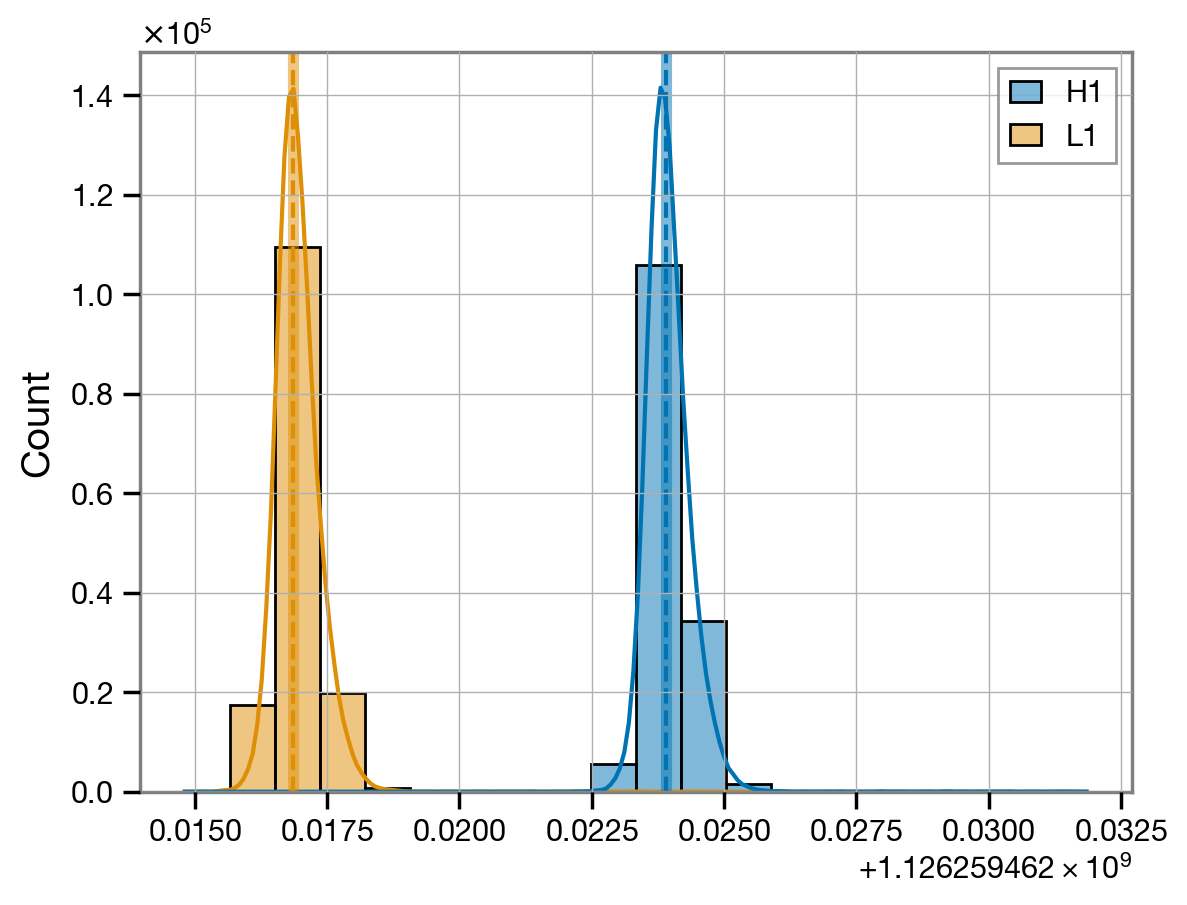

In [14]:
peak_times = fit.imr_result.get_peak_times()
sns.histplot(peak_times, bins=20, kde=True)
plt.axvline(fit.start_times['H1'], ls='--')
plt.axvline(fit.start_times['L1'], ls='--', c='C1')
plt.axvline(bp['H1'], lw=4, alpha=0.5)
plt.axvline(bp['L1'], lw=4, alpha=0.5, c='C1')

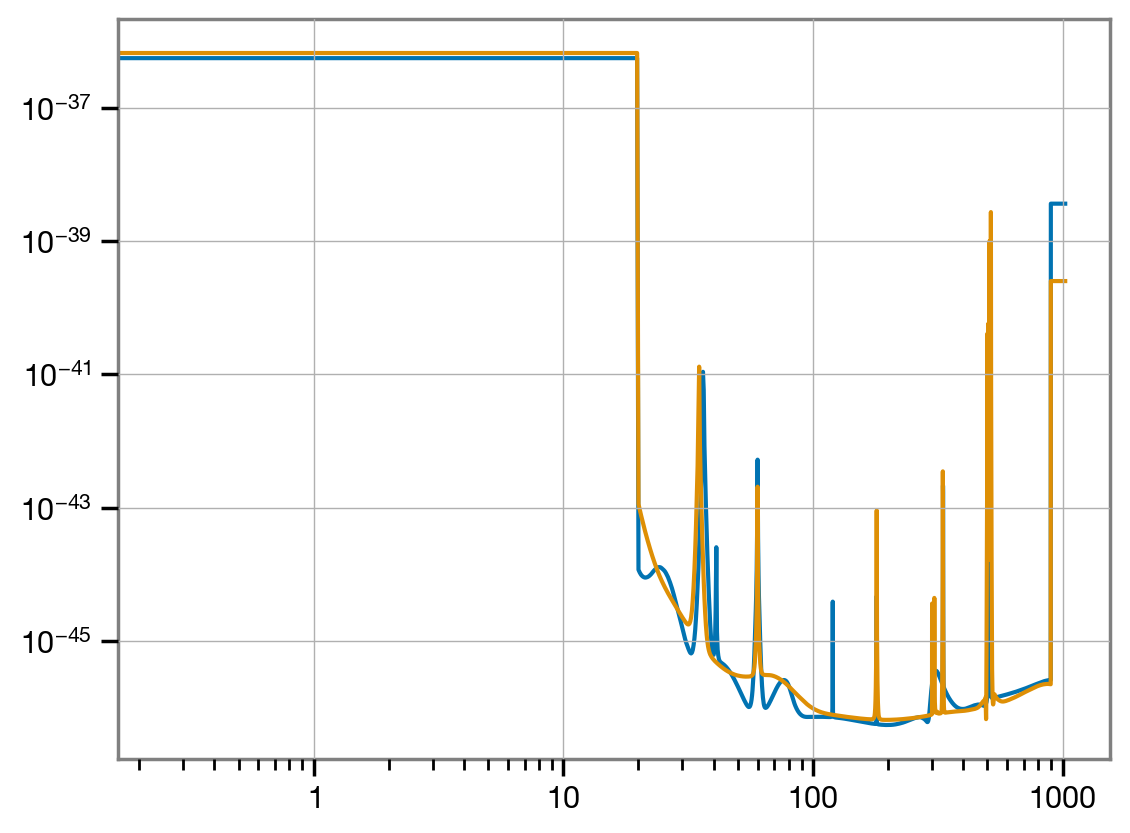

In [15]:
for ifo, acf in fit.acfs.items():
    p = acf.to_psd()
    plt.loglog(p)

In [30]:
fit.start_times

{'H1': 1126259462.4239063, 'L1': 1126259462.4168558}

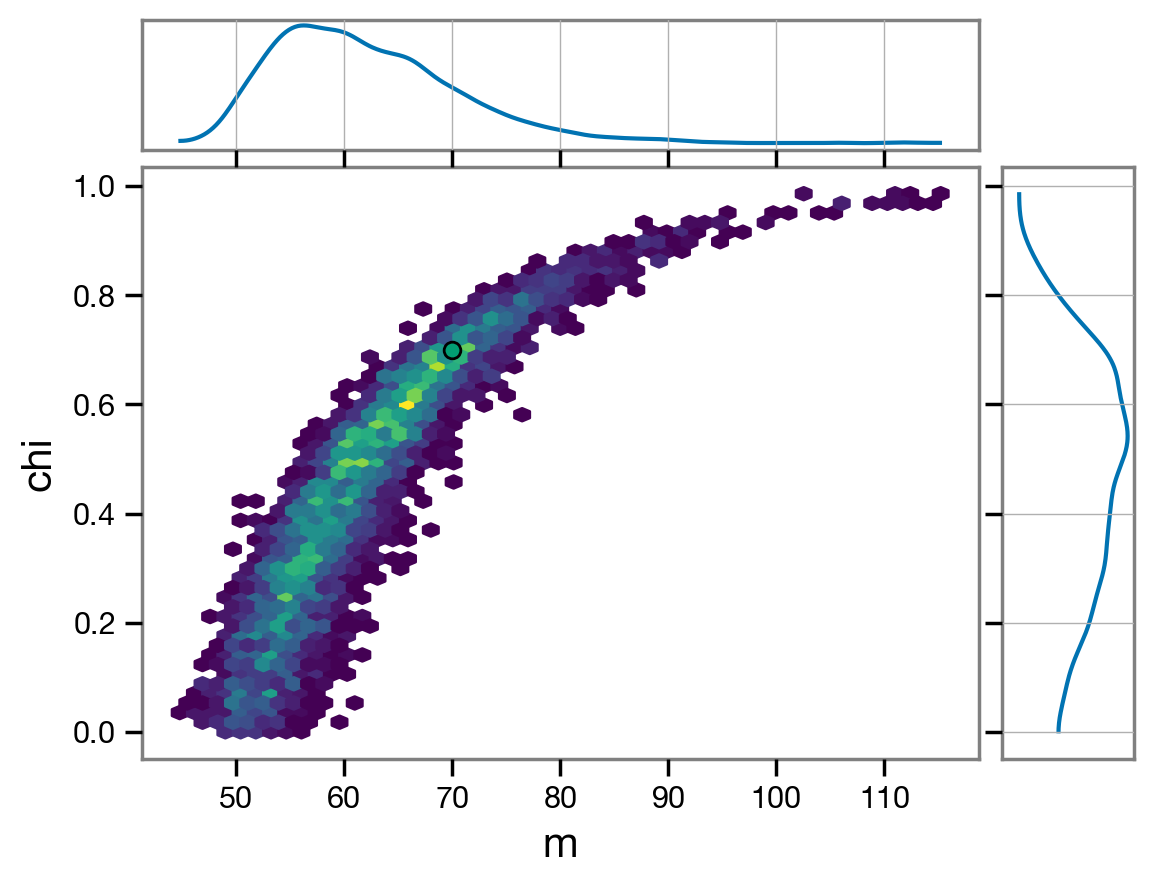

In [32]:
az.plot_pair(fit.result, var_names=['m', 'chi'], marginals=True,
             kind='hexbin', reference_values={'m': 70, 'chi': 0.7}, gridsize=50);

In [33]:
rd_samples = fit.result.get_parameter_dataframe(500)
df_imr = fit.imr_result.sample(500)

/opt/miniconda3/envs/ringdown-jax/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/ringdown-jax/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/ringdown-jax/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/miniconda3/envs/ringdown-jax/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: Future

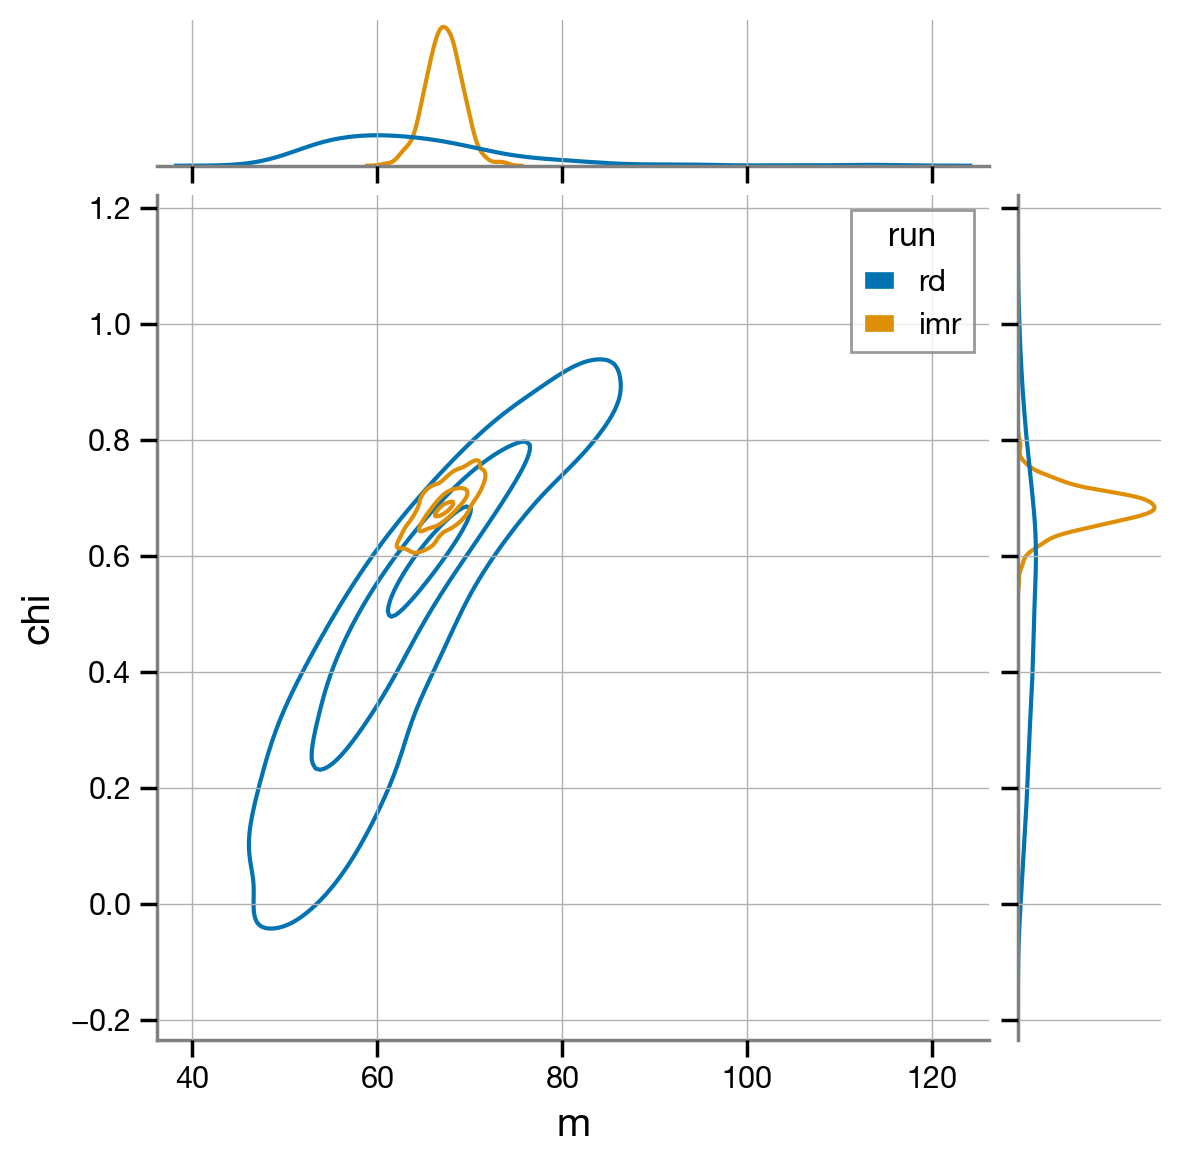

In [34]:
df = rd_samples[['m', 'chi']].copy()
df['run'] = 'rd'

df2 = pd.DataFrame({'m': df_imr.final_mass, 'chi': df_imr.final_spin, 'run': 'imr'})
df = pd.concat([df, df2], ignore_index=True)
sns.jointplot(data=df, x='m', y='chi', kind='kde', hue='run', fill=False, levels=[0.1, 0.5, 0.9], common_norm=False);

In [49]:
# from importlib import reload
# reload(rd.fit)

<module 'ringdown.fit' from '/Users/maxisi/src/ringdown/ringdown/fit.py'>

In [28]:
# config = fit.to_config('imr_test_config.ini')

In [30]:
# fit2 = rd.fit.Fit.from_config('imr_test_config.ini')

INFO:root:fetching 4.0 s long segment centered on 1126259462.391 [1126259460.391, 1126259464.391]
INFO:root:fetching open data from GWOSC
INFO:root:fetching 4.0 s long segment centered on 1126259462.391 [1126259460.391, 1126259464.391]
INFO:root:fetching open data from GWOSC
INFO:root:unused keyword arguments: {'ifos': ['H1', 'L1']}
